# Informe final de la carrera


Profundiza y ajusta la resolución de tus proyectos. Agrega una fuente de datos, prueba un modelo nuevo o responde una pregunta nueva. Elabora un informe final que describa el proceso de toma de decisiones. Sustenta la razón por la cual usaste las librerías y aplicaste los métodos al dataset. Todos tus hallazgos deberán ser comunicados en función de la problemática y las preguntas que buscabas responder.

## OBJETIVO 

**En base al resultado del proyecto 2, quiero probar si un modelo de boosting como XGBoost ayuda a predecir mejor el precio de la propiedad.**
**La propuesta es ver si performa mejor y lograr mejorar los resultados obtenidos con anterioridad.**


## Punto de partida: Proyecto 2

Importamos las librerias con las que vamos a trabajar.

In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

**Importo el Dataset y veo sus datos**

In [2]:
proyecto = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv') #importamos el dataset 
proyecto.head(2)

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta


**Voy a realizar un filtro sobre propiedad, trabajando sólo con departamento, PH y casa de Capital Federal; la superficie total debe ser mayor a la cubierta y debe tener como máximo 5 baños. El valor máximo a tomar por propiedad es de hasta USD$400.000.**

In [3]:
nprop = proyecto.property_type.isin(['Departamento', 'Casa', 'PH'])
nsup=(proyecto['surface_total']>=proyecto['surface_covered'])
nprecio= proyecto['price']<=400000
ncap= proyecto['l2']=='Capital Federal'
nban= proyecto['bathrooms']<=5


proyecto=proyecto[nprop & nsup & nprecio & ncap & nban]
proyecto.shape


(70059, 19)

**Realizamos Encoding con la variable "property_type"**

In [4]:
dummies= pd.get_dummies(proyecto['property_type'], prefix = 'property_type')
dummies

,property_type_Casa,property_type_Departamento,property_type_PH
0,0,1,0
1,0,0,1
2,0,0,1
3,0,0,1
5,0,0,1
...,...,...,...
146542,0,1,0
146543,0,1,0
146545,0,1,0
146549,0,0,1


**Concatenamos el Encoding con el Dataset**

In [5]:
concatenado_uno =pd.concat([proyecto,dummies], axis=1)
concatenado_uno.head(2)

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,...,surface_covered,price,currency,title,description,property_type,operation_type,property_type_Casa,property_type_Departamento,property_type_PH
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,...,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta,0,1,0
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,...,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta,0,0,1


**Elimino las variables que no utilizo**

In [6]:
proyecto_uno = concatenado_uno.drop(columns = ['start_date', 'end_date', 'lat', 'lon', 'currency','title', 'description', 'operation_type', 'l1', 'created_on', 'property_type', 'l2','l3'])
proyecto_uno.head(2)

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH
0,7.0,7.0,2.0,140.0,140.0,153000.0,0,1,0
1,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1


**Detección y remoción de outliers por el criterio de tres sigmas**

In [7]:
zscore_precio = zscore(proyecto_uno['price'])
zscore_suptot = zscore(proyecto_uno['surface_total'])
zscore_supcub = zscore(proyecto_uno['surface_covered'])
filtro_zscore = (abs(zscore_precio)>3) |  (abs(zscore_suptot)>3) | (abs(zscore_supcub)>3)
proyecto_dos= proyecto_uno[~filtro_zscore]

In [8]:
proyecto_dos.shape

(69947, 9)

**Definimos X e Y, realizamos train/test split**

In [9]:
X = proyecto_dos[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'property_type_Casa', 'property_type_Departamento', 'property_type_PH']] 
y = proyecto_dos['price']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Modelos Avanzados**

Vamos a utilizar Random Forest como Benchmark y voy a compararlo con el resultado de XGBoost.

Definimos la función.

In [11]:
def entrena_modelo (X_train, X_test, y_train, y_test, modelo):
    
    #Entrenamos el modelo y predecimos y_train e y_test:
    modelo.fit(X_train, y_train)
    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)
    
    #Imprimimos las metricas consideradas para evaluar el modelo:
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    rf = modelo.score(X_test, y_test)
    print(f'Score de modelo: {rf}')
    print(f'Raiz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raiz del error cuadrático medio en Test: {rmse_test}')
    
    #Graficamos la distribucion de errores:
    plt.figure(figsize = (15,6))
    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    plt.scatter(y_test,y_test_pred, s =2)    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()
    

    return rmse_train,rmse_test,rf

**Vamos a realizar optimización de hiperparámetros usando GridSearch**

In [12]:
n_estimators = [50,100,250]
max_depth = [100,150]


grid= {'n_estimators': n_estimators,
               'max_depth': max_depth,}

In [13]:
modelorf = GridSearchCV(RandomForestRegressor(random_state = 42),param_grid = grid, n_jobs = -1, cv = 3)

Score de modelo: 0.767736411618148
Raiz del error cuadrático medio en Train: 30817.096765178125
Raiz del error cuadrático medio en Test: 39757.85952752372


C:\Users\Juli\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Juli\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


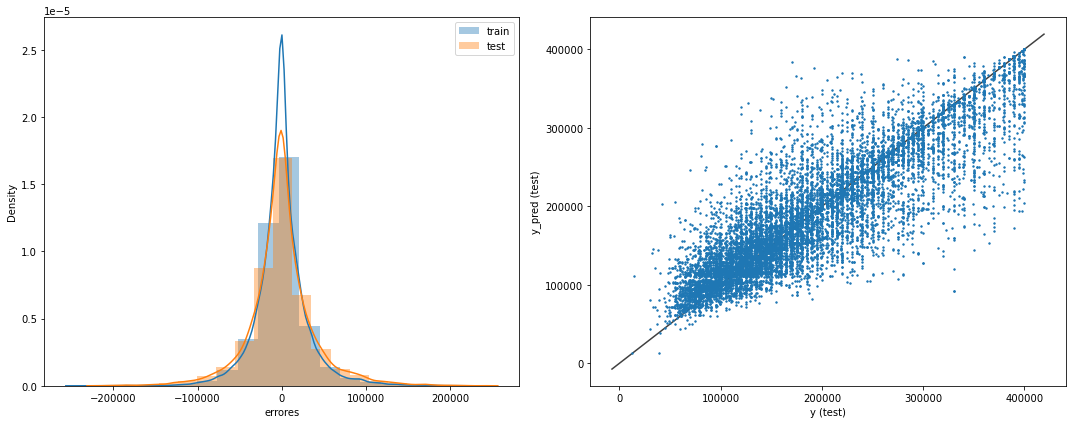

In [14]:
rmse_train_rf,rmse_test_rf,score_rf = entrena_modelo(X_train, X_test, y_train, y_test, modelorf)

In [15]:
best_params_rf =  modelorf.best_params_
print (f'Los mejores parametros son: {best_params_rf}')

Los mejores parametros son: {'max_depth': 100, 'n_estimators': 250}


**Vamos a entrenar XGBoost para ver si mejora el modelo**

In [16]:
eta = [0,1]
max_depth = [10,15,20]



In [17]:
grid= {'learning_rate': eta,
               'max_depth': max_depth,}

In [18]:
modelxgb = GridSearchCV(XGBRegressor(random_state=42), param_grid =grid, n_jobs = -1)

Score de modelo: 0.7385009494425154
Raiz del error cuadrático medio en Train: 29738.224985858556
Raiz del error cuadrático medio en Test: 42185.916373567896


C:\Users\Juli\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Juli\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


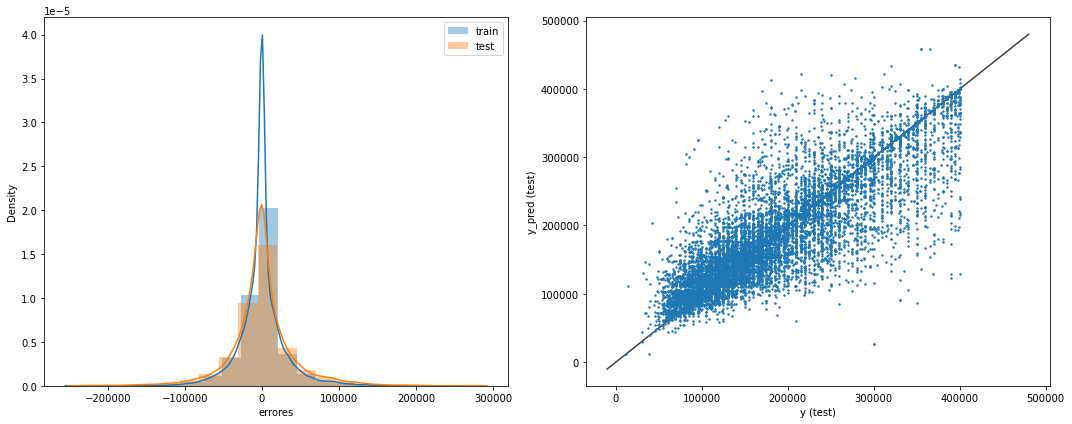

In [19]:
rmse_train_xgb,rmse_test_xgb,scorexgb = entrena_modelo(X_train, X_test, y_train, y_test, modelxgb)

In [20]:
best_params =  modelxgb.best_params_
print (f'Los mejores parametros son: {best_params}')

Los mejores parametros son: {'learning_rate': 1, 'max_depth': 20}


**Conclusiones**

* Elijo realizar Random Forest porque fue el modelo que mejor predijo en el proyecto 2.

* Esperaba que XGBOOST agregara valor al modelo pero no ocurrio. Mientras que Random Forest da un error de 30.814 en TRAIN y 39.700 en TEST, XGBoost da un error de 29.738 en TRAIN y 42.185 en TEST generando mayor overfitting. Si bien en train calcula un poco mejor, en test el error es mayor y tiene mucho más overfitting que Random Forest

* Al momento el modelo que mejor predice sigue siendo Random Forest.

* Como mejora, propondria incluir las variables LON y LAT para ver si al momento de realizar el escalado de datos, PCA y ejecutar los modelos avanzados mejora la predicción de nuestro modelo.